## Importing Needed Libraries

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau  
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import LearningRateScheduler  
from sklearn.model_selection import KFold  
from lifelines.utils import datetimes_to_durations

## Reading The Data

In [2]:
data_dir = "C:\\Users\\Hp\\Downloads\\ohii\\glucose_readings10.csv"
df = pd.read_csv(data_dir)

## Data Exploration

In [3]:
df.head()

,datetime,value
0,2021-09-13 11:36:37,236
1,2021-09-13 12:23:15,219
2,2021-09-13 13:50:58,169
3,2021-09-13 16:10:05,112
4,2021-09-13 17:13:46,94


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16893 entries, 0 to 16892
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  16893 non-null  object
 1   value     16893 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 264.1+ KB


### Set Date column as an index

In [5]:
df.set_index('datetime', inplace= True)

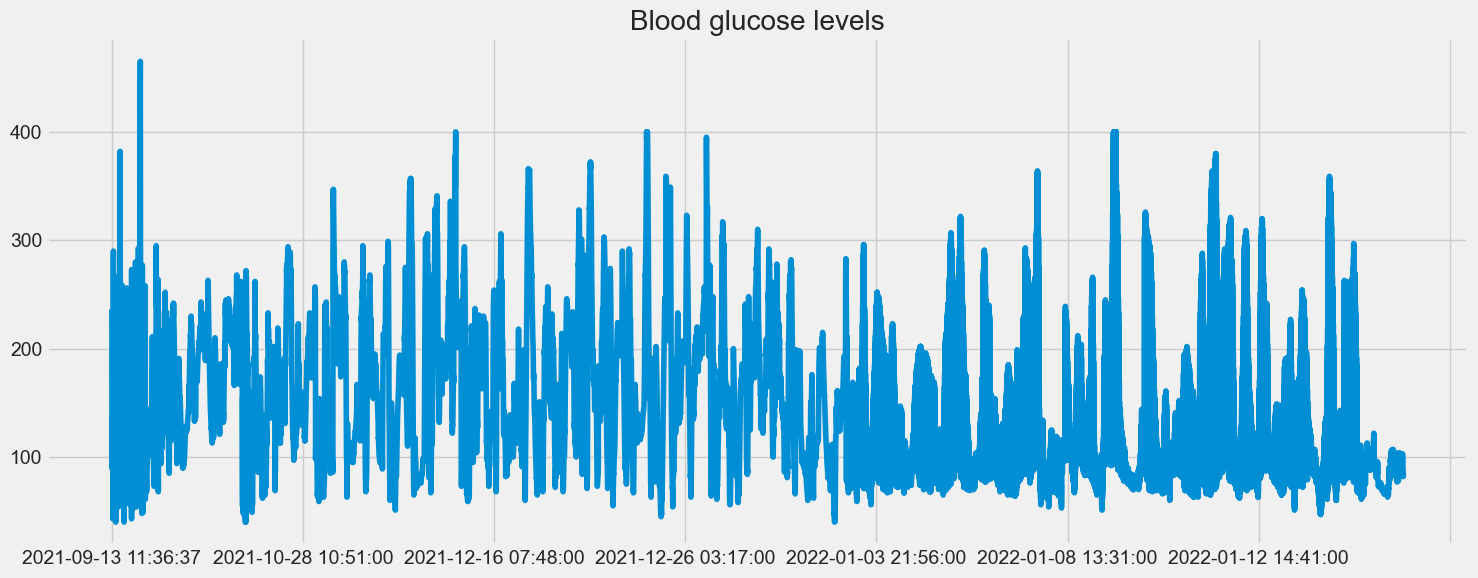

In [6]:
plt.figure(figsize=(15, 6))
df['value'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Blood glucose levels")
plt.tight_layout()
plt.show()

## Data Preprocessing

### Choosing Prediction Column

In [7]:
n_cols = 1
dataset = df["value"]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape


(16893, 1)

### Normalizing Data

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))

### Splitting the Data

In [9]:
# 75% to Train , 25% to Test
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 12669 Test Size : 4224


In [10]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(12669, 1)

In [9]:
import joblib
# حفظ الـ Scaler لاستخدامه لاحقًا في التطبيق
joblib.dump(scaler, "C:\\Users\\Hp\\Desktop\\tracking\\scaler.pkl")

print("تم حفظ scaler.pkl بنجاح!")

تم حفظ scaler.pkl بنجاح!


### Creating training set

In [11]:
# Creating a Training set with 60 time-steps
x_train = []
y_train = []
time_steps = 10
n_cols = 1

for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, :n_cols])
    y_train.append(train_data[i, :n_cols])
    if i<=time_steps:
        print('X_train: ', x_train)
        print('y_train:' , y_train)

X_train:  [array([[0.46117647],
       [0.42117647],
       [0.30352941],
       [0.16941176],
       [0.12705882],
       [0.11529412],
       [0.11529412],
       [0.16705882],
       [0.16705882],
       [0.22823529]])]
y_train: [array([0.17176471])]


In [12]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [13]:
# Reshaping the input to (n_samples, time_steps, n_feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))

In [14]:
x_train.shape , y_train.shape

((12659, 10, 1), (12659, 1))

## LSTM Model

### Model Dtructure

In [15]:
from tensorflow.keras.layers import GRU
model = Sequential([
    GRU(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    GRU(64, return_sequences=False),
    Dense(32),
    Dense(16),
    Dense(1)
])


# Compile the model  
model.compile(optimizer="adam", loss='mse',metrics=["mean_absolute_error"])
model.summary()

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,847 (128.31 KB)

 Trainable params: 32,847 (128.31 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [16]:
# Early stopping and learning rate reduction  
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)  



# Fit the model with callbacks  
history = model.fit(x_train, y_train,  
                    validation_split=0.1,  
                    epochs=100, 
                    batch_size=8,  
                    callbacks=[early_stopping, reduce_lr])  

Epoch 1/100
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0052 - mean_absolute_error: 0.0443 - val_loss: 0.0022 - val_mean_absolute_error: 0.0321 - learning_rate: 0.0010
Epoch 2/100
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0264 - val_loss: 0.0023 - val_mean_absolute_error: 0.0312 - learning_rate: 0.0010
Epoch 3/100
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0260 - val_loss: 0.0018 - val_mean_absolute_error: 0.0275 - learning_rate: 0.0010
Epoch 4/100
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0249 - val_loss: 0.0019 - val_mean_absolute_error: 0.0293 - learning_rate: 0.0010
Epoch 5/100
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0022 - mean_absolute_error: 0.0259 - val_loss: 0.0035 - val_mean_absolute_error: 0.0450 - learning_rate: 0.0010
Epoch 6/100
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0020 - mean_absolute_error: 0.0248 - val_loss:

### Model Evaluation

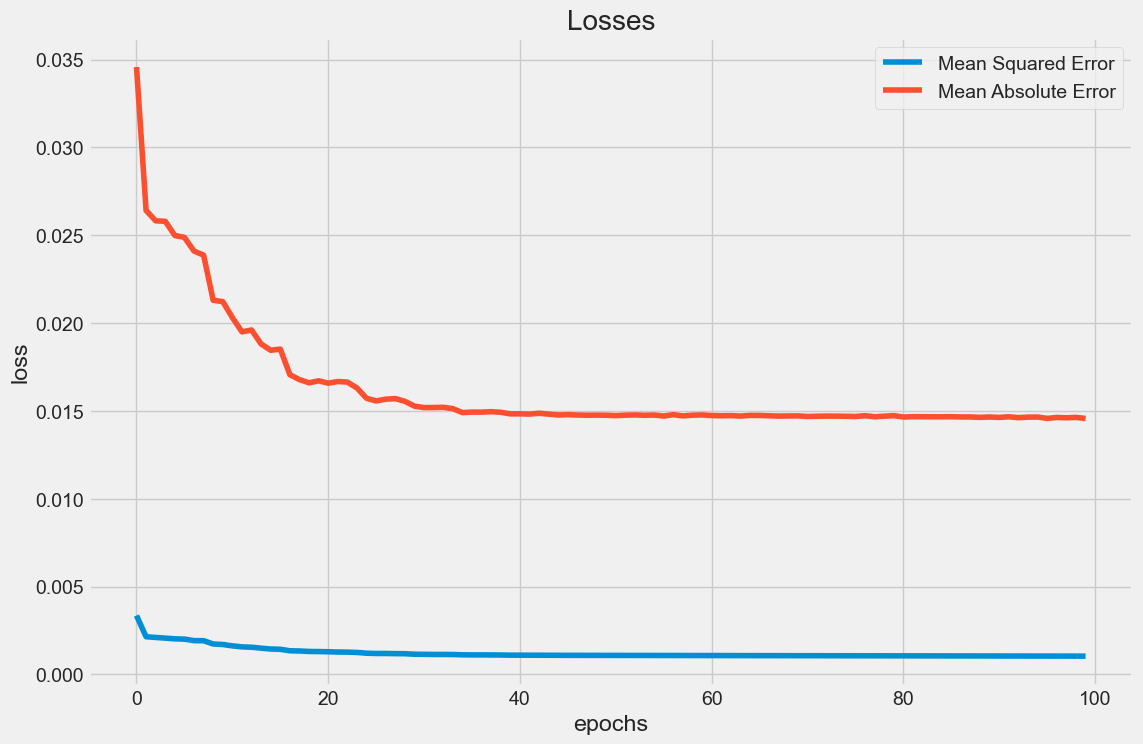

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Predection

### Creating testing set

In [18]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [19]:
x_test.shape , y_test.shape

((4224, 60, 1), (4224, 1))

In [20]:
# Get Prediction
predictions = model.predict(x_test)

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [21]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(4224, 1)

### Root mean square error

In [22]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

3.38

In [23]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,194.136887,181.0
1,96.853081,105.0
2,183.837967,178.0
3,104.591377,107.0
4,177.927521,182.0
...,...,...
4219,91.610931,82.0
4220,77.336075,82.0
4221,79.482460,82.0
4222,82.929497,83.0


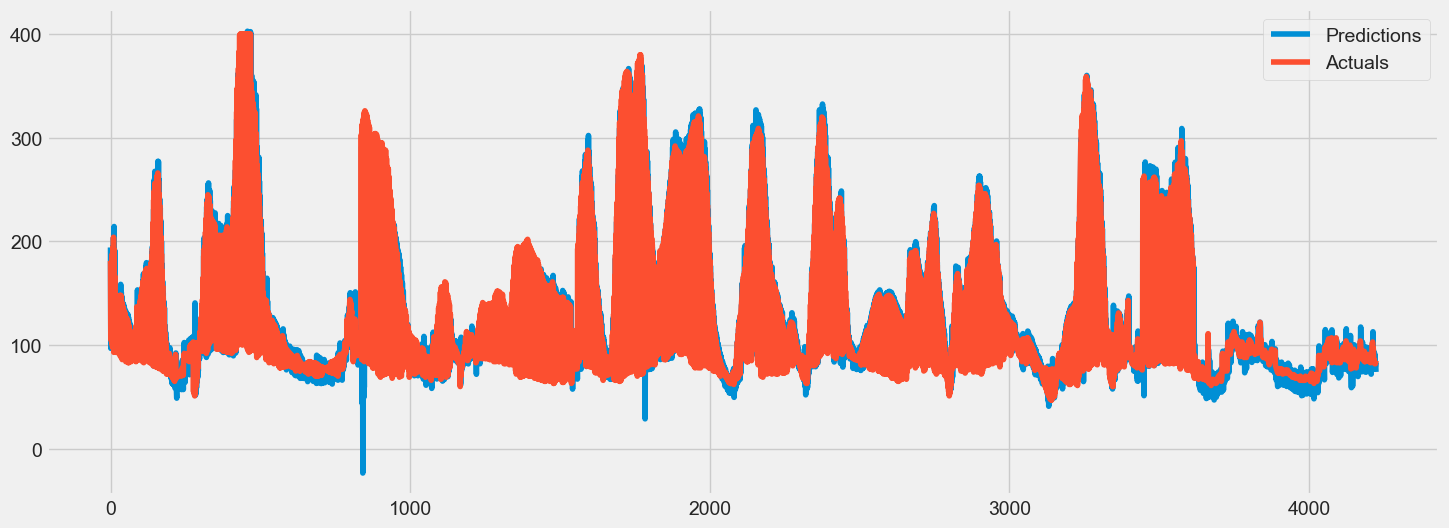

In [24]:
plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

### Visualize Predictions with The Data
for one feature

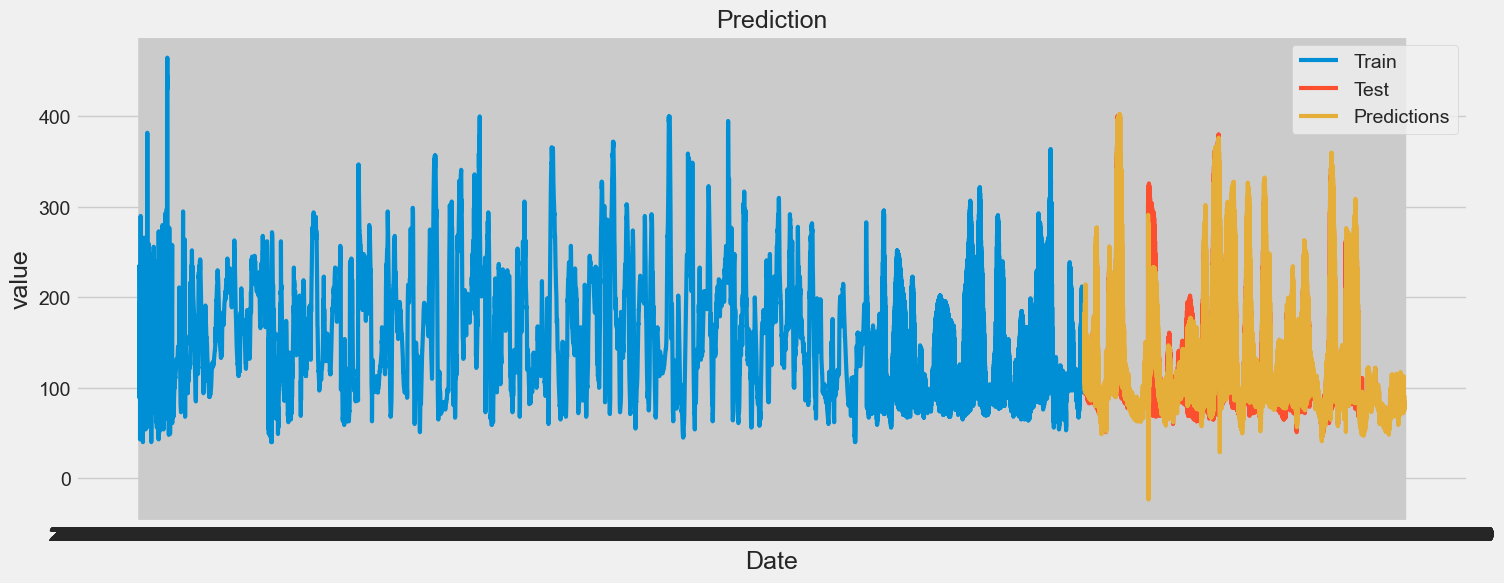

In [26]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('value', fontsize= 18)
plt.plot(train['value'], linewidth= 3)
plt.plot(test['value'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

In [27]:
import xml.etree.ElementTree as ET
def parse_xml(file_path):
    """Parse XML file and extract datetime and glucose values."""
    data_list = []
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()

        for event in root.findall(".//event"):
            timestamp = event.get("ts")
            value = event.get("value")
            if timestamp and value:
                data_list.append({"datetime": timestamp, "value": int(value)})

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")

    return pd.DataFrame(data_list)


In [38]:
# 🔹 **تحميل بيانات الاختبار من XML**
test_file = "C:\\Users\\Hp\\Downloads\\ohii\\OhioT1DM\\2020\\train\\540-ws-training.xml"
df_test = parse_xml(test_file)

# ✅ **تحقق من البيانات المستخرجة**
print(df_test.head())  # طباعة أول 5 صفوف
print(f"🔹 Available columns in df_test: {df_test.columns.tolist()}")

# ✅ **التحقق مما إذا كان df_test فارغًا**
if df_test.empty:
    raise ValueError("🚨 The DataFrame `df_test` is empty! Check XML file structure.")

# ✅ **تحويل `datetime` إلى Timestamp**
df_test["datetime"] = pd.to_datetime(df_test["datetime"], format="%d-%m-%Y %H:%M:%S", errors="coerce")

# ✅ **ترتيب البيانات حسب `datetime`**
df_test = df_test.sort_values(by="datetime")


❌ Error processing C:\Users\Hp\Downloads\ohii\OhioT1DM\2020\train\540-ws-training.xml: invalid literal for int() with base 10: '0.8'
              datetime  value
0  19-05-2027 11:36:29     76
1  19-05-2027 11:41:29     72
2  19-05-2027 11:46:29     68
3  19-05-2027 11:51:29     65
4  19-05-2027 11:56:29     63
🔹 Available columns in df_test: ['datetime', 'value']


In [39]:
df_test["scaled_value"] = scaler.transform(df_test[["value"]])

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [40]:
# 🔹 **إعداد بيانات الاختبار**
test_data = df_test["scaled_value"].values
x_test, y_test = [], []

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i])
    y_test.append(test_data[i])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 🔹 **توقع القيم**
predictions = model.predict(x_test)

# **إعادة القيم إلى المدى الأصلي**
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 🔹 **حساب RMSE**
RMSE = np.sqrt(np.mean((y_test - predictions) ** 2)).round(2)
print(f"🔹 RMSE: {RMSE}")

# 🔹 **عرض النتائج**
preds_acts = pd.DataFrame({"Predictions": predictions.flatten(), "Actuals": y_test.flatten()})
print(preds_acts.head())

390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
🔹 RMSE: 26.85
   Predictions  Actuals
0    43.561840     49.0
1    45.967236     71.0
2    63.787724     54.0
3    71.973343     60.0
4    44.064648     71.0


In [45]:
# حفظ النموذج بعد التدريب
model.save("C:\\Users\\Hp\\Downloads\\glucose_model.h5")
print("✅ تم حفظ النموذج!")

✅ تم حفظ النموذج!


In [48]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

custom_objects = {"mse": MeanSquaredError()}

model = load_model("C:\\Users\\Hp\\Downloads\\glucose_model.h5", custom_objects=custom_objects)
print("✅ تم تحميل النموذج!")

✅ تم تحميل النموذج!
